In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Text Classification

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset :- http://mlg.ucd.ie/datasets/bbc.html 

SHAPE OF DATASET:  (2225, 2) 

COLUMNS IN DATASET:  Index(['category', 'text'], dtype='object') 

CATEGORIES:  ['tech' 'business' 'sport' 'entertainment' 'politics'] 

DATA SAMPLE: 

            category                                               text
1462          sport  redknapp s saints face pompey tie new southamp...
1384       business  air passengers win new eu rights air passenger...
2155       politics  cherie accused of attacking bush cherie blair ...
986            tech  video phone help for deaf people deaf people w...
1492  entertainment  x factor show gets second series tv talent sho... 


NUMBER OF SAMPLES IN EACH CATEGORY: 



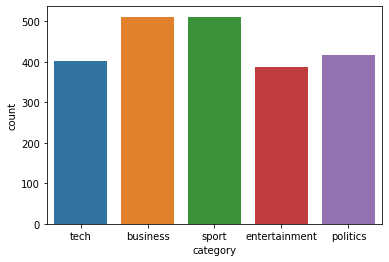

In [5]:
# Read data frame

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/bbc-text.csv')

# Description of the dataset
print('SHAPE OF DATASET: ', df.shape, '\n\nCOLUMNS IN DATASET: ', df.columns, '\n\nCATEGORIES: ', df.category.unique(), '\n\nDATA SAMPLE: \n\n', df.sample(n=5), '\n\n')

# Plotting number of samples within each category
print('NUMBER OF SAMPLES IN EACH CATEGORY: \n')
sns.countplot(df.category)

In [4]:

# DATA CLEANING
print('Data cleaning in progress...')

# Tokenize
df['text_clean'] = df['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')

# Lemmatization
lem = nltk.stem.wordnet.WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Lemmatization complete.\nData cleaning complete.\n')

Data cleaning in progress...
Tokenization complete.
Stop words removed.
Numbers, punctuation and special characters removed.
Lemmatization complete.
Data cleaning complete.



In [5]:
# Classification using word2vec vectorizer

vec_model = Word2Vec(df['text_clean'])
w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.syn0))

class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])

class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
      return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)

clf_models = {
    'Naive Bayes': GaussianNB(), 
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

clf_params = {
    'Naive Bayes': { }, 
    'SVC': { 'kernel': ['linear', 'rbf'] },
    'Decision Tree': { 'min_samples_split': [2, 5] }, 
    'Perceptron': { 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'min_samples_split': [2, 5] }
}

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)

for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec vectorizer', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(key, ':')
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))

Naive Bayes :
Accuracy: 0.402 	Precision: 0.412 	Recall: 0.374 		F1: 0.363

SVC :
Accuracy: 0.362 	Precision: 0.147 	Recall: 0.291 		F1: 0.194

Decision Tree :
Accuracy: 0.396 	Precision: 0.391 	Recall: 0.392 		F1: 0.389

Perceptron :
Accuracy: 0.366 	Precision: 0.148 	Recall: 0.295 		F1: 0.197

Gradient Boosting :
Accuracy: 0.490 	Precision: 0.474 	Recall: 0.480 		F1: 0.474



In [7]:
# Classification using TFIDF vectorizer

# Vectorize training and testing data
def Vectorize(vec, X_train, X_test):    
    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    print('Vectorization complete.\n')
    
    return X_train_vec, X_test_vec

# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Precision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    
    return

models = {
    'Naive Bayes': MultinomialNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] }, 
    'Decision Tree': { 'min_samples_split': [1, 2, 5] }, 
    'Perceptron': { 'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'learning_rate': [0.05, 0.1], 'min_samples_split': [2, 5] }
}

# Encode label categories to numbers
enc = LabelEncoder()
df['category'] = enc.fit_transform(df['category'])
labels = list(enc.classes_)

# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(), X_train, X_test)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Precision: 0.975 	Recall: 0.976 		F1: 0.975

Decision Tree : {'min_samples_split': 2}
Precision: 0.797 	Recall: 0.793 		F1: 0.794

Perceptron : {'activation': 'tanh', 'alpha': 0.001}
Precision: 0.986 	Recall: 0.987 		F1: 0.986

Gradient Boosting : {'learning_rate': 0.1, 'min_samples_split': 5}
Precision: 0.955 	Recall: 0.954 		F1: 0.954



# Sentiment Analysis

In [7]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [8]:
#Importing Sentiment Analyzer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

In [9]:
#Traversing through column containing text and checking the polarity of it

scores=[]
for i in range(len(df)):
    scores.append(sia.polarity_scores(df.loc[i,'text']))

In [10]:
df['scores'] = scores

In [11]:
df.head()

,category,text,scores
0,tech,tv future in the hands of viewers with home th...,"{'neg': 0.02, 'neu': 0.888, 'pos': 0.092, 'com..."
1,business,worldcom boss left books alone former worldc...,"{'neg': 0.141, 'neu': 0.782, 'pos': 0.077, 'co..."
2,sport,tigers wary of farrell gamble leicester say ...,"{'neg': 0.023, 'neu': 0.888, 'pos': 0.089, 'co..."
3,sport,yeading face newcastle in fa cup premiership s...,"{'neg': 0.03, 'neu': 0.875, 'pos': 0.095, 'com..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,"{'neg': 0.046, 'neu': 0.848, 'pos': 0.106, 'co..."


In [12]:
df['compound']=df['scores'].apply(lambda c:c['compound'])
df.head()

,category,text,scores,compound
0,tech,tv future in the hands of viewers with home th...,"{'neg': 0.02, 'neu': 0.888, 'pos': 0.092, 'com...",0.9934
1,business,worldcom boss left books alone former worldc...,"{'neg': 0.141, 'neu': 0.782, 'pos': 0.077, 'co...",-0.9728
2,sport,tigers wary of farrell gamble leicester say ...,"{'neg': 0.023, 'neu': 0.888, 'pos': 0.089, 'co...",0.9403
3,sport,yeading face newcastle in fa cup premiership s...,"{'neg': 0.03, 'neu': 0.875, 'pos': 0.095, 'com...",0.9607
4,entertainment,ocean s twelve raids box office ocean s twelve...,"{'neg': 0.046, 'neu': 0.848, 'pos': 0.106, 'co...",0.9218


In [13]:
#Making Prediction based on compound column

df['pred_label']=df['compound'].apply(lambda x:"pos" if( x > 0) else "neg")
df.head()

,category,text,scores,compound,pred_label
0,tech,tv future in the hands of viewers with home th...,"{'neg': 0.02, 'neu': 0.888, 'pos': 0.092, 'com...",0.9934,pos
1,business,worldcom boss left books alone former worldc...,"{'neg': 0.141, 'neu': 0.782, 'pos': 0.077, 'co...",-0.9728,neg
2,sport,tigers wary of farrell gamble leicester say ...,"{'neg': 0.023, 'neu': 0.888, 'pos': 0.089, 'co...",0.9403,pos
3,sport,yeading face newcastle in fa cup premiership s...,"{'neg': 0.03, 'neu': 0.875, 'pos': 0.095, 'com...",0.9607,pos
4,entertainment,ocean s twelve raids box office ocean s twelve...,"{'neg': 0.046, 'neu': 0.848, 'pos': 0.106, 'co...",0.9218,pos


In [14]:
df['pred_label'].value_counts()

pos    1582
neg     643
Name: pred_label, dtype: int64